# 7-1. 프로젝트 : 주식 예측에 도전해 보자


ARIMA를 통해 시계열 데이터를 예측하는 과정을 진행해 보았습니다. 이제 실제 주식값 예측에 도전해 봅시다. 

데이터는 과거의 일자별 시세입니다. 우선 대한민국 대장주 삼성전자에 대한 주식 시세를 예측해 봅시다.



우선 주요 라이브러리 버전을 확인해 봅시다.






In [62]:
import pandas
import sklearn
import statsmodels

print(pandas.__version__)
print(sklearn.__version__)
print(statsmodels.__version__)

1.3.3
1.0
0.13.0


## STEP 1 : 시계열 데이터 준비

칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
    
날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있습니다.

우리는 종가(Close)만 사용하겠습니다. (주식 시장은 정해진 시간 동안만 거래가 가능합니다. 종가란 하루의 장이 마감하였을 때의 가격입니다.)

In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [64]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-05-18,47950.0,49100.0,47600.0,48800.0,46788.835938,20481981
2020-05-19,50100.0,50500.0,49700.0,50300.0,48227.015625,25168295
2020-05-20,50000.0,50200.0,49800.0,50000.0,47939.382813,14896899
2020-05-21,50300.0,50400.0,49850.0,49950.0,47891.437500,14949266
2020-05-22,49600.0,49800.0,48600.0,48750.0,46740.894531,19706284
...,...,...,...,...,...,...
2021-05-12,80800.0,81200.0,79800.0,80000.0,80000.000000,35812268
2021-05-13,78900.0,79600.0,78400.0,78500.0,78500.000000,31490096
2021-05-14,79000.0,80300.0,78900.0,80100.0,80100.000000,16450920


In [65]:
ts_close = df['Close']  # 우선은 데이터 확인용이니 time series 의 이니셜을 따서 'ts_close'라고 이름 붙여줍시다!
print(type(ts_close))
ts_close.head()

<class 'pandas.core.series.Series'>


Date
2020-05-18    48800.0
2020-05-19    50300.0
2020-05-20    50000.0
2020-05-21    49950.0
2020-05-22    48750.0
Name: Close, dtype: float64

## STEP 2 : 시계열 안정성 분석
* 정성적 그래프 분석
* 정량적 Augmented Dicky-Fuller Test

### **시계열 안정성의 정성적 분석**

시각화를 통해 안정성(Stationarity) 여부를 확인

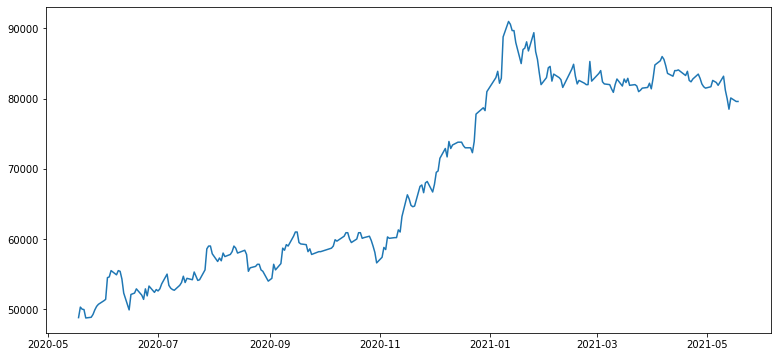

In [66]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정해 줍니다.

# 시계열(time series) 데이터를 차트로 그려 봅시다. 특별히 더 가공하지 않아도 잘 그려집니다.
plt.plot(ts_close)

### 시간 추이에 따라 일정한 평균, 분산, 자기공분산의 패턴이 나타나는지 통계적 특성을 더 명료하게 시각화
- 일정 시간 내 `구간 통계치(Rolling Statistics)`를 시각화하는 함수 생성
    
    `현재 타임 스텝` 부터 `window에 주어진 타임 스텝 이전` 사이
    
    1) 구간의 평균(rolling mean, `이동평균`)과
    
    2) 구간의 표준편차(rolling std, `이동표준편차`)를
    
    원본 시계열과 함께 시각화해 보면 좀 더 뚜렷한 경향성을 확인할 수 있음

In [67]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

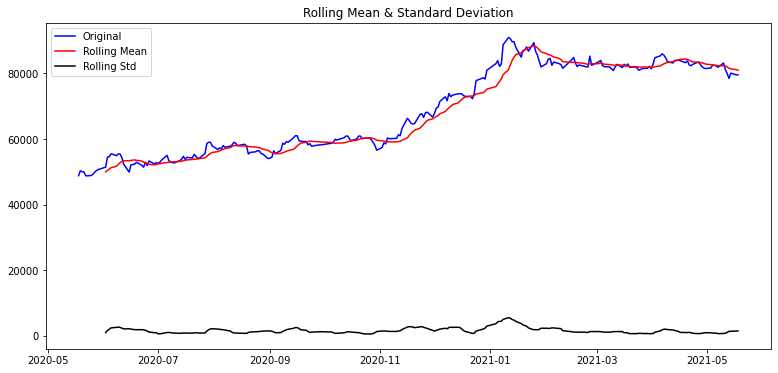

In [68]:
plot_rolling_statistics(ts_close, window=12)

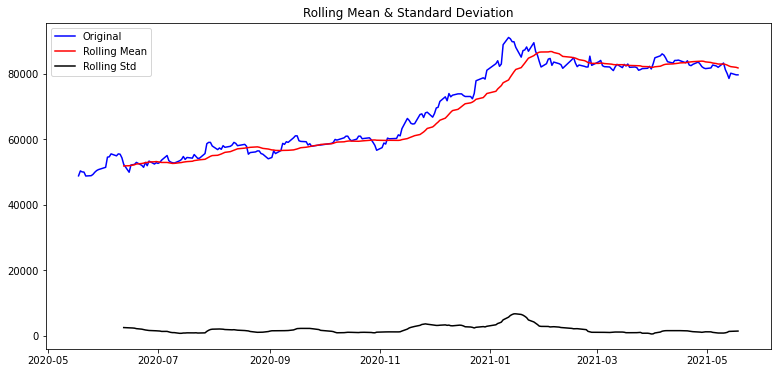

In [69]:
plot_rolling_statistics(ts_close, window=20)
## 주말을 제외하고 평일 5일 X 4주 = 20일을 한달로 계산

### 📊 분석 :
시간의 추이에 따라 시계열의 평균과 지속적으로 커지는 패턴이며 분산이 고르지 않음 > 안정적이지 못함

### Original data ADFTest
statsmodels 패키지에서 제공하는 adfuller 메서드를 이용해 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행

In [70]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [71]:
augmented_dickey_fuller_test(ts_close)

Results of Dickey-Fuller Test:
Test Statistic                  -1.222649
p-value                          0.663778
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### 📊 분석 :
오리지날 데이터에서는 ADFtest 결과 -1.22값을 얻었으며 p-value가 0.66값이다. 

따라서 이는 귀무가설을 기각하기에 충분하지 않아 '데이터가 안정적이지 못하다'라고 해석할 수 있다.

## STEP 3 : 각종 전처리 수행
* 결측치 처리
* 로그 변환

### 결측치 처리

In [72]:
# 결측치 유무 확인
ts_close[ts_close.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 결측치 처리
# ts_close = ts_close.interpolate(method='time')
# ts_close[ts_close.isna()]

Series([], Name: Close, dtype: float64)

### 📊 분석 :
결측치가 존재하지 않음

### 로그 변환

**1-1. 로그함수 변환**

시간 추이에 따라 분산이 점점 커지고 있다는 점을 고려 

\>> 시계열이 이런 특성을 보일 경우에는 로그함수로 변환

In [73]:
# 로그 변환
ts_log = np.log(ts_close)
type(ts_log)

pandas.core.series.Series

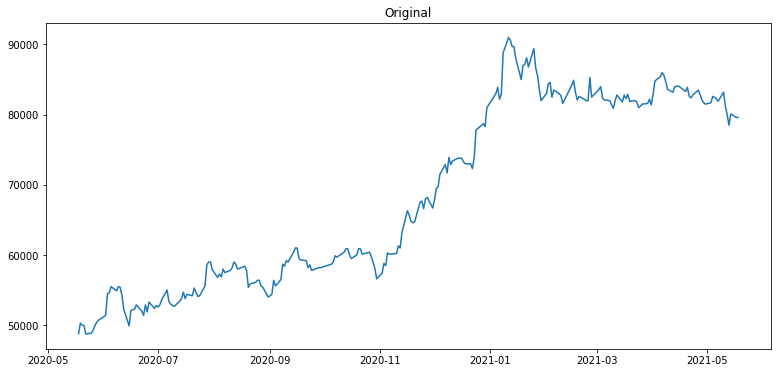

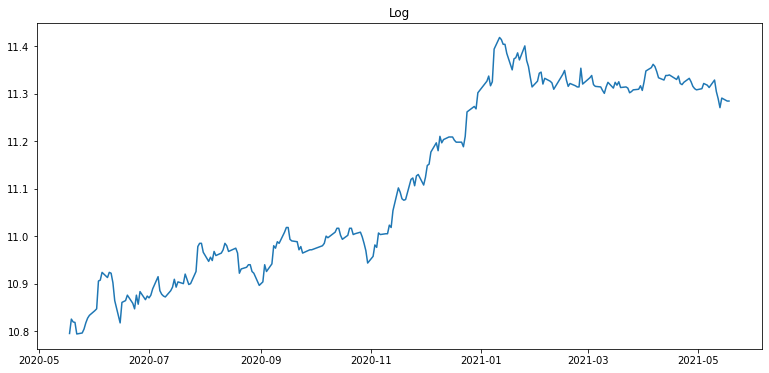

In [74]:
plt.plot(ts_close)
plt.title("Original")
plt.show()
plt.plot(ts_log)
plt.title("Log")
plt.show()

In [75]:
# 로그 변환의 효과가 어떠했는지 따져 보기 위해 Augmented Dickey-Fuller Test를 수행
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                  -1.383525
p-value                          0.590149
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64


### 📊 분석 :
Log 변환 데이터로 ADFtest를 실행한 결과, -1.38값을 얻었으며 p-value가 0.59값이다. 

정성적으로도 시간 추이에 따른 분산이 꽤 일정해진 것을 확인할 수 있다.

test값과 p-value 모두 줄어들었지만, 여전히 두 값들 모두 귀무가설을 기각하기에 충분하지 않아 '데이터가 안정적이지 못하다'라고 해석할 수 있다.

하지만 아직 가장 두드러지는 문제점은 시간 추이에 따라 평균이 계속 증가한다는 것이다.

## STEP 4 : 시계열 분해
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

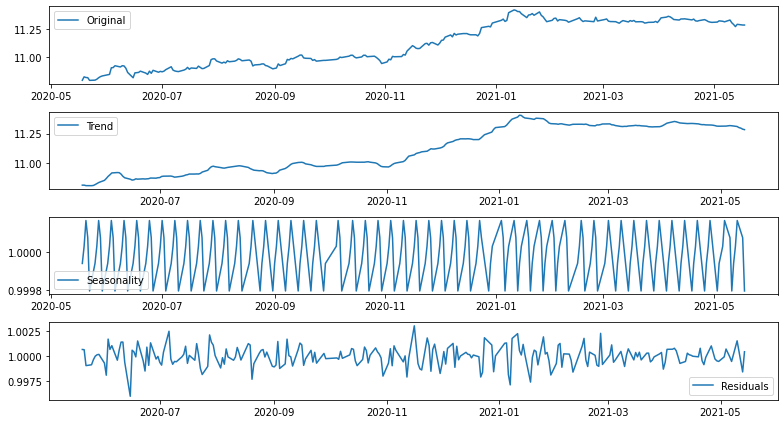

In [76]:
# seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 5)
decomposition2 = seasonal_decompose(ts_log, model='multiplicative', period = 20)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성
residual2 = decomposition2.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 📊 분석 :

**Trend** : 2020년 7월 이후 점점 상승하다가 2020년 11월 이후 급등하여 안정을 찾는 추세를 가지고 있다.

**Seasonality** : 
1) window = 20 (평일 5일 x 4주 = 20일)
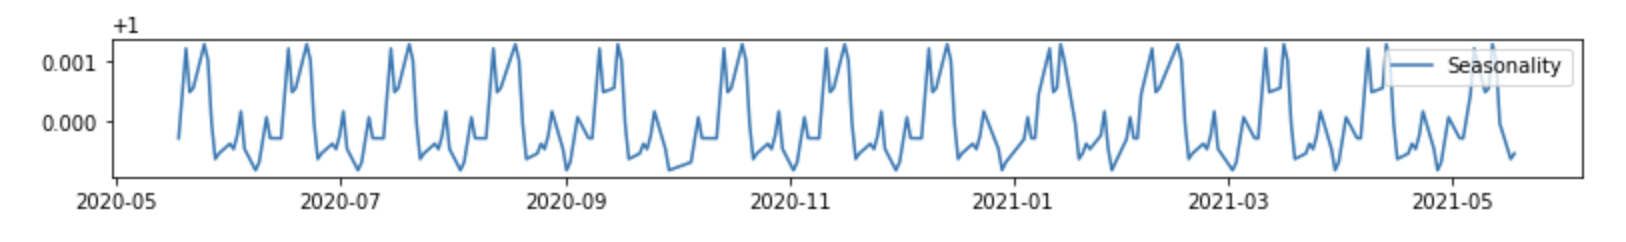
2) window = 5 (평일 5일)
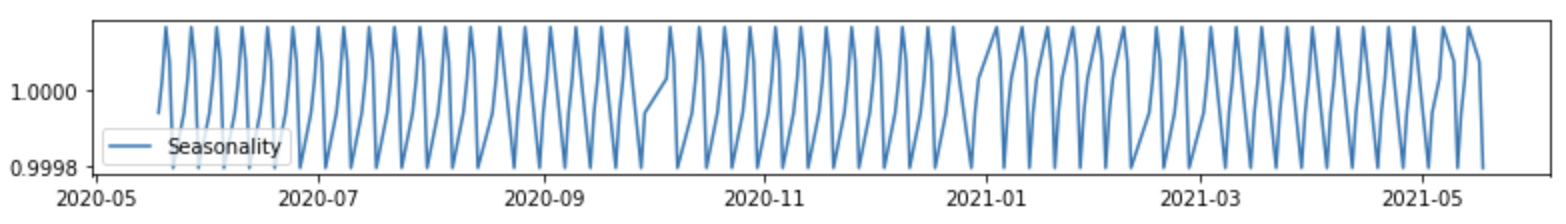

**Residual** : Original 시계열에서 Trend와 Seasonality를 제거하고 난 나머지를 Residual이라고 합니다. (Trend+Seasonality+Residual=Original)

### Residual에 대해 안정성 여부

In [77]:
residual

Date
2020-05-18         NaN
2020-05-19         NaN
2020-05-20    1.000661
2020-05-21    1.000640
2020-05-22    0.999060
                ...   
2021-05-12    0.999416
2021-05-13    0.998433
2021-05-14    1.000438
2021-05-17         NaN
2021-05-18         NaN
Name: resid, Length: 250, dtype: float64

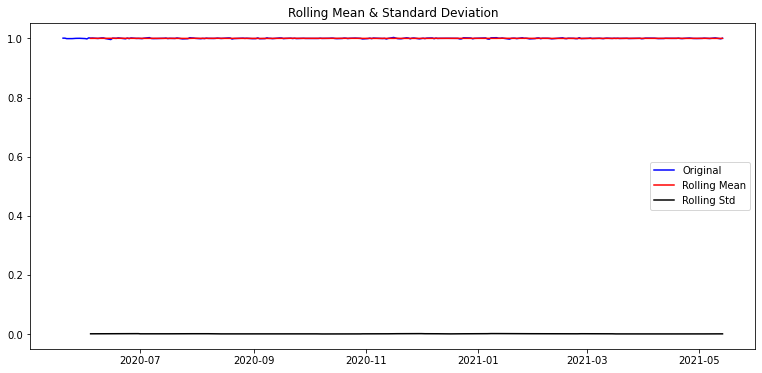

In [78]:
plt.rcParams["figure.figsize"] = (13,6)
plot_rolling_statistics(residual)

In [79]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -9.783378e+00
p-value                        6.641628e-17
#Lags Used                     6.000000e+00
Number of Observations Used    2.390000e+02
Critical Value (1%)           -3.458011e+00
Critical Value (5%)           -2.873710e+00
Critical Value (10%)          -2.573256e+00
dtype: float64


In [80]:
residual2.dropna(inplace=True)
augmented_dickey_fuller_test(residual2)

Results of Dickey-Fuller Test:
Test Statistic                -6.204111e+00
p-value                        5.712839e-08
#Lags Used                     0.000000e+00
Number of Observations Used    2.290000e+02
Critical Value (1%)           -3.459233e+00
Critical Value (5%)           -2.874245e+00
Critical Value (10%)          -2.573541e+00
dtype: float64


### 📊 분석:
Decomposing을 통해 얻어진 Residual은 압도적으로 낮은 p-value를 보여 줌.

이 정도면 확실히 예측 가능한 수준의 안정적인 시계열을 얻음

또한 window를 20으로 설정했을때와 5로 설정하였을 때를 비교하면, 5로 설정하여 주별로 분석하는것이 안정성이 더 높음

## STEP 5 : 학습, 테스트 데이터셋 생성
* 학습, 테스트 데이터셋 분리





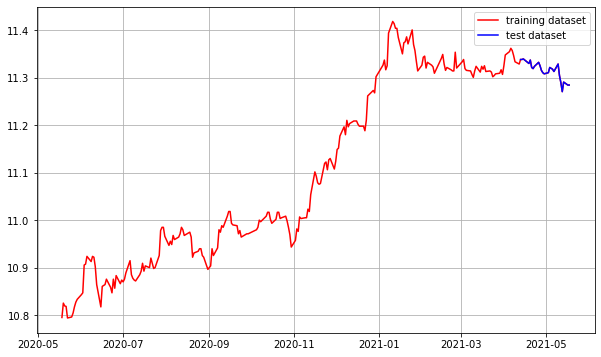

In [81]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()


## STEP 6 : 적정 ARIMA 모수 찾기
* ACF, PACF 그려보기 -> p,q 구하기
* 차분 안정성 확인 -> d 구하기

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


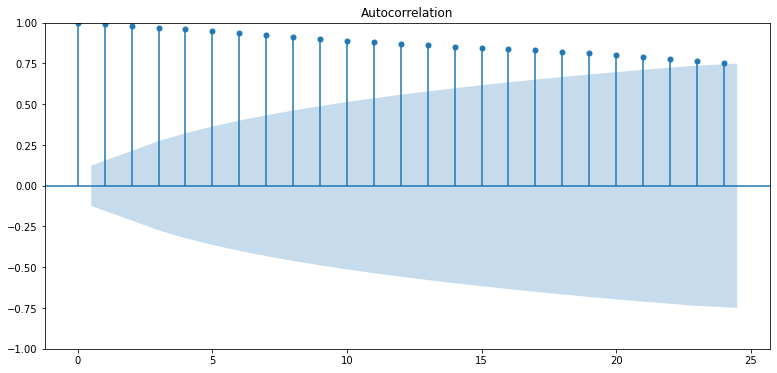

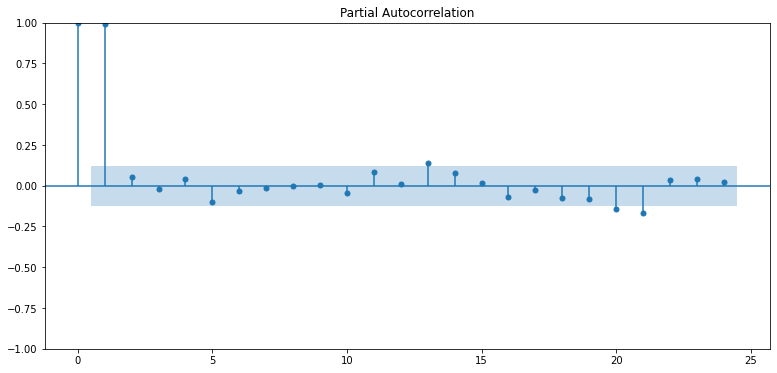

In [82]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 📊 분석:
    
ACF를 통해 MA 모델의 시차 q를 결정하고, PACF를 통해 AR 모델의 시차 p를 결정할 수 있음
    
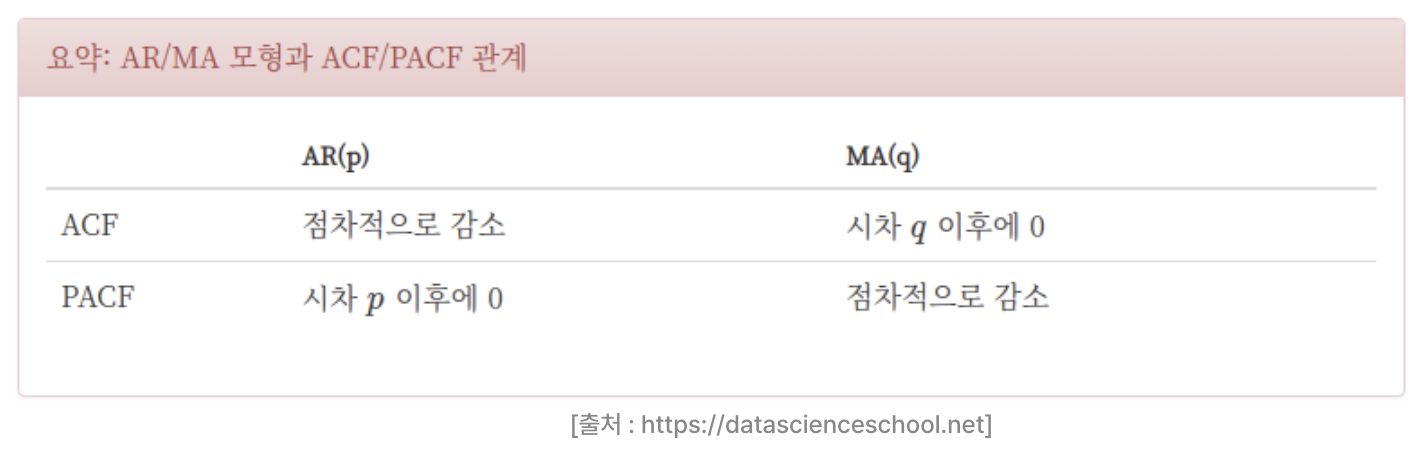
    
이 결론에 따라 보자면 **PACF** 그래프를 볼 때 `p=1`이 매우 적합함 >> `p`가 2 이상인 구간에서 **PACF**는 거의 0에 가까워지고 있기 때문
    
**PACF**가 0이라는 의미는 현재 데이터와 `p`시점 떨어진 이전의 데이터는 상관도가 0, 즉 아무 상관 없는 데이터이기 때문에 고려할 필요가 없다는 뜻이다.

반면 **ACF**는 점차적으로 감소하고 있어서 `AR(1)` 모델에 유사한 형태

`q`에 대해서는 적합한 값이 없어 보임 >> MA를 고려할 필요가 없다면 `q=0`

따라서 **p=1**, **q=0**

Results of Dickey-Fuller Test:
Test Statistic                -1.553699e+01
p-value                        2.183738e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.480000e+02
Critical Value (1%)           -3.456996e+00
Critical Value (5%)           -2.873266e+00
Critical Value (10%)          -2.573019e+00
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -1.029320e+01
p-value                        3.525823e-18
#Lags Used                     7.000000e+00
Number of Observations Used    2.400000e+02
Critical Value (1%)           -3.457894e+00
Critical Value (5%)           -2.873659e+00
Critical Value (10%)          -2.573229e+00
dtype: float64


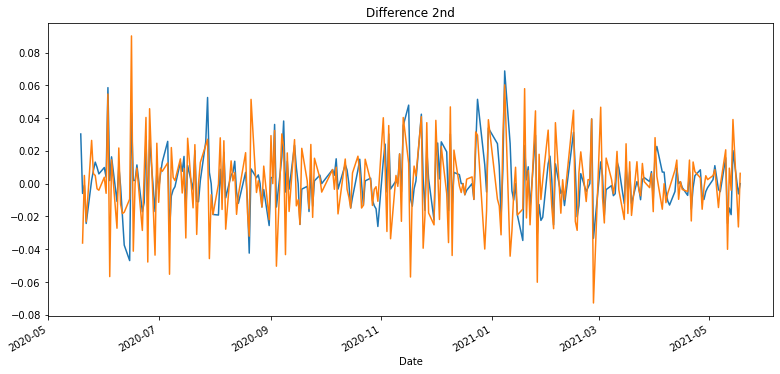

In [83]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 📊 분석:
1차 차분으로도 충분히 안정성이 보장되므로 **d=1**로 설정

## STEP 7 : ARIMA 모델 훈련과 테스트
* ARIMA 모델 빌드와 훈련
* 모델 테스트 및 플로팅
* 최종 예측 모델 정확도 측정(MAPE)

In [84]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(1, 0, 1))  
fitted_m = model.fit() 

print(fitted_m.summary())

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 583.370
Date:                Thu, 29 Feb 2024   AIC                          -1158.741
Time:                        09:17:14   BIC                          -1145.076
Sample:                             0   HQIC                         -1153.226
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.0896      0.127     87.360      0.000      10.841      11.338
ar.L1          0.9942      0.006    157.934      0.000       0.982       1.007
ma.L1          0.0392      0.063      0.623      0.5

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


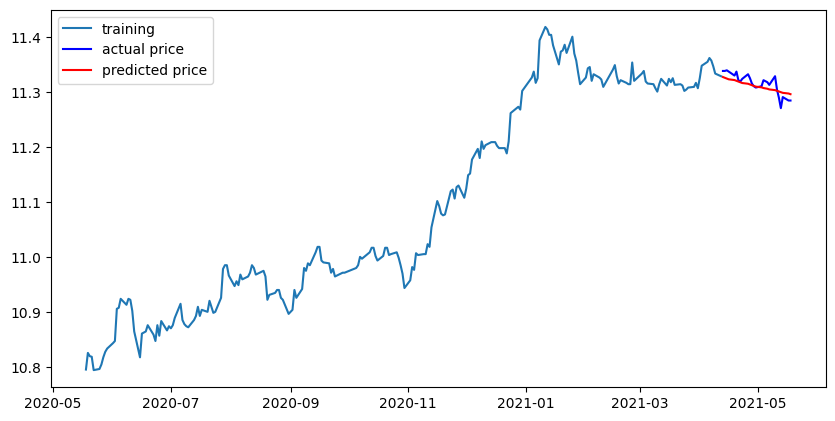

In [85]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [86]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  1057119.8161340475
MAE:  850.8270312480739
RMSE:  1028.1633217218202
MAPE: 1.04%


### 📊 분석 :
MAPE 기준으로 0.05% 정도의 오차율 >> 만족스러운 성능

# SM Entertainment의 주식데이터로 적용해보기

In [87]:
# Time Series 생성
dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/SMCE.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-03-01,0.00130,0.00140,0.00100,0.0011,0.0011,23939527
2023-03-02,0.00110,0.00125,0.00100,0.0010,0.0010,10613883
2023-03-03,0.00100,0.00110,0.00100,0.0011,0.0011,2276050
2023-03-06,0.00110,0.00120,0.00100,0.0010,0.0010,9449218
2023-03-07,0.00100,0.00110,0.00100,0.0010,0.0010,2489400
...,...,...,...,...,...,...
2024-02-22,0.00063,0.00063,0.00060,0.0006,0.0006,200
2024-02-23,0.00068,0.00070,0.00065,0.0007,0.0007,1767338
2024-02-26,0.00070,0.00070,0.00070,0.0007,0.0007,1152200


In [88]:
ts_close = df['Close']  # 우선은 데이터 확인용이니 time series 의 이니셜을 따서 'ts_close'라고 이름 붙여줍시다!
print(type(ts_close))
ts_close.head()

<class 'pandas.core.series.Series'>


Date
2023-03-01    0.0011
2023-03-02    0.0010
2023-03-03    0.0011
2023-03-06    0.0010
2023-03-07    0.0010
Name: Close, dtype: float64

In [89]:
# 결측치 유무 확인
ts_close[ts_close.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다.

# 결측치 처리
# ts_close = ts_close.interpolate(method='time')
# ts_close[ts_close.isna()]

Series([], Name: Close, dtype: float64)

In [90]:
# 로그 변환
ts_log = np.log(ts_close)
ts_log

Date
2023-03-01   -6.812445
2023-03-02   -6.907755
2023-03-03   -6.812445
2023-03-06   -6.907755
2023-03-07   -6.907755
                ...   
2024-02-22   -7.418581
2024-02-23   -7.264430
2024-02-26   -7.264430
2024-02-27   -7.264430
2024-02-28   -7.264430
Name: Close, Length: 251, dtype: float64

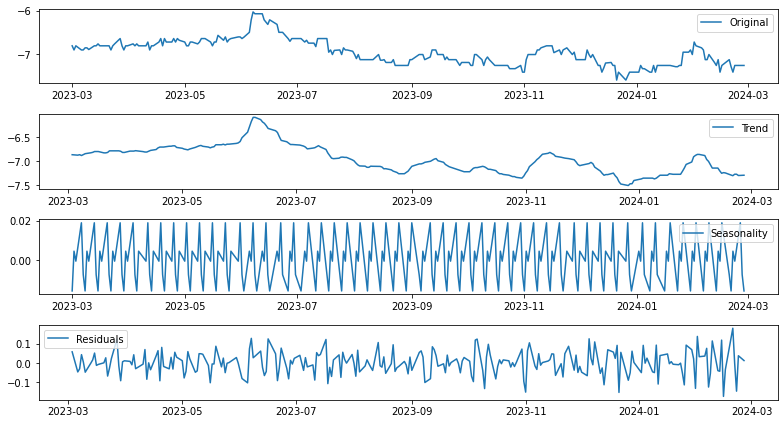

In [91]:
# seasonal_decompose 
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, period = 5)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

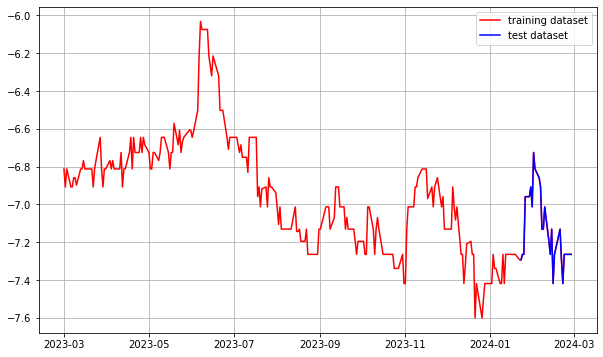

In [92]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

/opt/conda/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


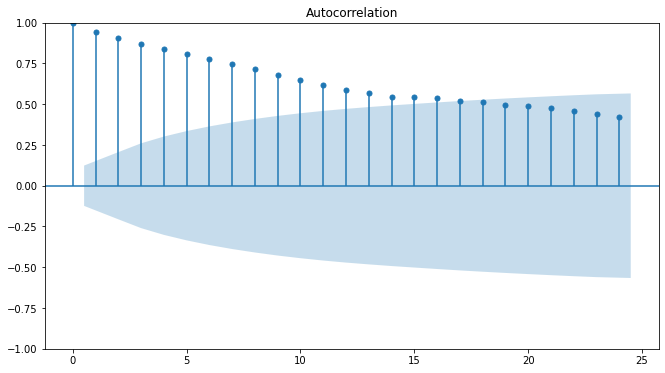

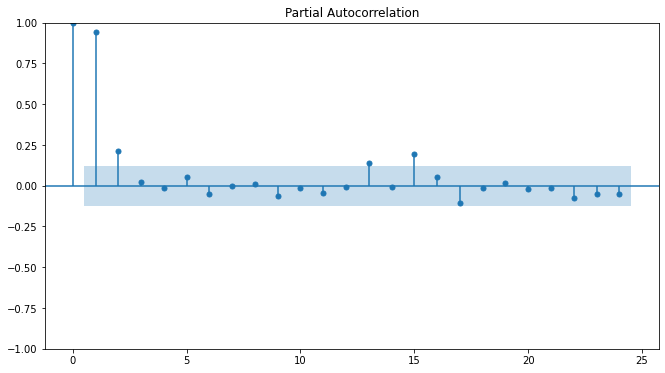

In [93]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                 -19.832917
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64
Results of Dickey-Fuller Test:
Test Statistic                -7.062030e+00
p-value                        5.193850e-10
#Lags Used                     1.400000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


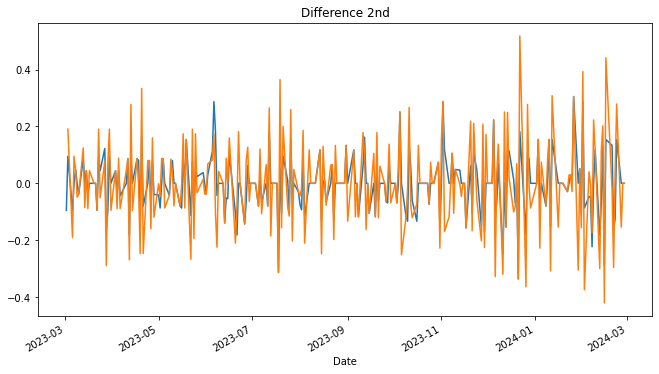

In [94]:
# 차분 안정성 확인 -> d 구하기

# 1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 혹시 필요한 경우 2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

### 📊 분석 :
* p = 2

* q = 0 or q = 16

* d = 1

In [95]:
from statsmodels.tsa.arima.model import ARIMA
# Build Model
model = ARIMA(train_data, order=(0, 1, 2))  
fitted_m = model.fit() 

print(fitted_m.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  225
Model:                 ARIMA(0, 1, 2)   Log Likelihood                 218.709
Date:                Thu, 29 Feb 2024   AIC                           -431.419
Time:                        09:17:17   BIC                           -421.184
Sample:                             0   HQIC                          -427.287
                                - 225                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2095      0.061     -3.413      0.001      -0.330      -0.089
ma.L2          0.0190      0.066      0.289      0.773      -0.110       0.148
sigma2         0.0083      0.001     14.006      0.0

/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


/opt/conda/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


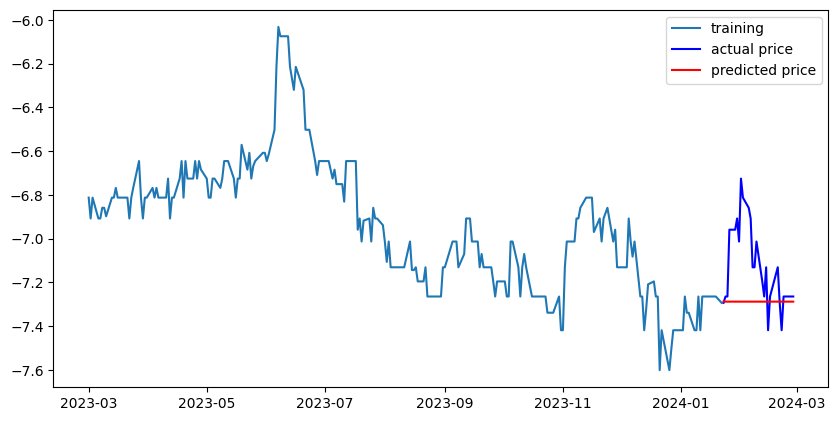

In [96]:
# Forecast : 결과가 fc에 담깁니다. 
fc = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf
fc = np.array(fc)
# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.legend()
plt.show()

In [97]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  4.168301853544684e-08
MAE:  0.000143560948245587
RMSE:  0.00020416419503783428
MAPE: 15.30%


## 회고
처음 시계열 데이터를 다뤄보고 생소한 모델을 사용하여 예측값을 만들어보았다.

어려운 개념들이 많았던만큼, 관련 자료와 논문을 찾아 많이 추가 공부를 해보았던 점은 잘한 점이고,
수학적 설명이 포함된 글은 잘 이해하지 못하고 그냥 넘어갔던 점이 아쉬웠다. 조금 더 시간을 갖고 수학적 설명도 이해할 수 있게 깊이 공부할 수 있는 실력을 만드는것도 앞으로 성장하는데 있어 중요하다고 생각한다.

프로젝트에서는 ts_log데이터를 모델에 적용하는것에 대해서 많은 고민을 했다.
ts_log는 아직 상승하는 추세를 가지고 있는 평균이나 주기성을 제거하거나 정리하지 못한 데이터임에도 불구하고 residuals가 아닌 log변환 데이터를 train 데이터로 사용하는 것이 이해가 잘 되지 않았다.

**찾아 본 결과,**


시간 분해 후 로그 변환 결과 또는 잔차 데이터를 사용하여 데이터를 분할할지 결정하는 것은 여러 가지 요소에 따라 달라집니다. 일반적으로 다음과 같은 사항을 고려해야 합니다.

1. 데이터의 특성

로그 변환 결과: 로그 변환은 데이터의 변동성을 줄이고 정규 분포에 가깝게 만드는 데 도움이 됩니다. 데이터가 비대칭적이거나 이상치가 많은 경우 로그 변환 후 데이터 분할을 사용하는 것이 좋습니다.
잔차 데이터: 잔차 데이터는 추세, 계절성 및 기타 요소를 제거한 후 남은 데이터입니다. 잔차 데이터는 데이터의 순수한 변동성을 나타냅니다. 데이터가 정규 분포에 가까운 경우 잔차 데이터를 사용하여 데이터 분할을 사용하는 것이 좋습니다.

2. 모델링 방법

선형 모델: 선형 모델은 데이터가 정규 분포를 따르는 가정을 기반으로 합니다. 따라서 데이터가 정규 분포에 가깝지 않은 경우 모델링 결과가 정확하지 않을 수 있습니다. 이러한 경우 로그 변환 후 데이터 분할을 사용하는 것이 좋습니다.
비선형 모델: 비선형 모델은 데이터 분포에 대한 가정을 하지 않습니다. 따라서 데이터가 정규 분포를 따르지 않더라도 비선형 모델을 사용하여 정확한 모델링 결과를 얻을 수 있습니다. 이러한 경우 잔차 데이터를 사용하여 데이터 분할을 사용하는 것이 좋습니다.

3. 예측 목적

점 예측: 점 예측은 미래의 특정 시점의 값을 예측하는 것입니다. 로그 변환 후 데이터 분할은 데이터의 변동성을 줄여 예측 정확도를 높일 수 있습니다.
구간 예측: 구간 예측은 미래의 값이 범위 내에 있을 확률을 예측하는 것입니다. 잔차 데이터를 사용하여 데이터 분할은 데이터의 변동성을 보다 정확하게 반영하여 구간 예측 정확도를 높일 수 있습니다.

4. 경험적 지식

이전 경험이나 전문 지식을 통해 데이터 분할 방법에 대한 정보가 있을 수 있습니다. 이러한 정보는 데이터 분할 방법을 결정하는 데 도움이 될 수 있습니다.

5. 실험 및 비교

두 가지 방법 모두 실험하여 비교하는 것이 가장 좋은 방법입니다. 두 방법으로 모델링을 수행하고 결과를 비교하여 어떤 방법이 더 나은 결과를 제공하는지 확인할 수 있습니다.
결론

데이터 분할 방법은 데이터의 특성, 모델링 방법, 예측 목적, 경험적 지식 및 실험 결과를 고려하여 결정해야 합니다. 일반적으로 데이터가 비대칭적이거나 이상치가 많은 경우 로그 변환 후 데이터 분할을 사용하는 것이 좋습니다. 데이터가 정규 분포에 가까운 경우 잔차 데이터를 사용하여 데이터 분할을 사용하는 것이 좋습니다.

라는 답을 얻게 되었다. 하지만 아직 완벽하게 이해는 되지 않아 이 부분에 대해 전체적으로 함께 얘기를 해볼 수 있으면 좋을것 같다.

### 📊분석 :
오차율 15.30%로 조금 아쉬운 결과가 나옴.